In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from igraph import *

In [2]:
curr_dir = !pwd
pfam_version = "31"

significantly_similar_pairs = pd.read_csv(curr_dir[0]+"/pfam-v"+pfam_version+"/sig_pairs_pvals0.001_cols10_2directions.csv", sep='\t', index_col=0)

In [3]:
#Create vertexes in igraph format
domains_list1 = significantly_similar_pairs["sim_dom1"].unique()
domains_list2 = significantly_similar_pairs["sim_dom2"].unique()
vertices_list = np.unique(np.concatenate((domains_list1, domains_list2), axis=0))

#Create edges in igraph format
edges_list = []
for index, row in significantly_similar_pairs.iterrows():
    sim_dom1 = row["sim_dom1"]
    sim_dom2 = row["sim_dom2"]
    edges_list.append((sim_dom1, sim_dom2))

In [25]:
len(edges_list)

760

## Creating the graph

In [209]:
significantly_similar_pairs.columns

Index([u'index', u'sim_dom1', u'sim_dom2', u'prob1', u'pval1', u'score1',
       u'aligned_cols1', u'prob2', u'pval2', u'score2', u'ident_perc2',
       u'ident_perc1', u'aligned_cols2', u'score_norm1', u'score_norm2'],
      dtype='object')

In [5]:
#Creating the graph
gr = Graph()
gr.add_vertices(vertices_list)
gr.add_edges(edges_list)
gr.es["scores1"] = significantly_similar_pairs["score1"].tolist()
gr.es["pvals1"] = significantly_similar_pairs["pval1"].tolist()
gr.es["scores2"] = significantly_similar_pairs["score2"].tolist()
gr.es["pvals2"] = significantly_similar_pairs["pval2"].tolist()
gr.es["score_norm1"] = significantly_similar_pairs["score_norm1"].tolist()
gr.es["score_norm2"] = significantly_similar_pairs["score_norm2"].tolist()

In [6]:
#Normalize similarity scores to represent distance (lower = similar)
norm_scores1 = [x/(max(gr.es["score_norm1"])+1) for x in gr.es["score_norm1"]] #Adding 1 so that max similarity will be positive and not 0
norm_scores2 = [x/(max(gr.es["score_norm2"])+1) for x in gr.es["score_norm2"]] #Adding 1 so that max similarity will be positive and not 0
distances1 = [1-x for x in norm_scores1]
distances2 = [1-x for x in norm_scores2]

min_dist = []
for i in range(len(distances1)):
    min_dist.append(min(distances1[i], distances2[i]))

gr.es["distances"] = min_dist

### Visualizing connected components individually

In [36]:
#Connected components
x = gr.components()
y = x.subgraphs()

In [37]:
len(x.sizes())

84

In [22]:
def plot_sub_graph(graph, filename, savefile=False):
    
#     pvals = graph.es["pvals"]
#     pval_per = 0.0001
    #graph.es["is_sig"] = [True if x <= pval_per else False for x in pvals]
    
    visual_style = {}
    visual_style["vertex_size"] = 10
    visual_style["layout"] = graph.layout("fr")
    visual_style["vertex_color"] = "blue"
    #visual_style["edge_width"] = [3 - 2 * int(is_sig) for is_sig in graph.es["is_sig"]]
    #visual_style["vertex_label"] = graph.vs["name"]
    if (savefile):
        plot_obj = plot(graph, "pfam-v"+pfam_version+"/graphs/"+filename+".pdf", **visual_style)
    else:
        plot_obj = plot(graph, **visual_style)
    return plot_obj

#### Analyze biggest component

In [12]:
#Find the biggest component
biggest_size = max(x.sizes())
biggest_idx = x.sizes().index(biggest_size)

In [13]:
big_component = y[biggest_idx]
print big_component.vcount()
print big_component.ecount()
print big_component.degree()
print big_component.density()

34
404
[31, 28, 30, 30, 31, 31, 29, 28, 2, 25, 27, 27, 27, 26, 5, 26, 25, 25, 30, 14, 27, 23, 26, 27, 30, 28, 30, 27, 13, 27, 26, 14, 2, 11]
0.720142602496


In [14]:
degrees = [31, 28, 30, 30, 31, 31, 29, 30, 2, 25, 27, 28, 27, 26, 7, 26, 27, 25, 30, 18, 27, 24, 26, 27, 30, 29, 31, 27, 13, 28, 27, 15, 2, 12]
degrees = np.array(degrees)

In [15]:
max(degrees)

31

In [16]:
big_component.vs["name"]

['AAA',
 'AAA_11',
 'AAA_18',
 'AAA_33',
 'AAA_5',
 'AAA_6',
 'AAA_7',
 'AAA_8',
 'AAA_9',
 'ABC_tran',
 'ADK',
 'Arf',
 'DEAD',
 'Dynamin_N',
 'Dynein_heavy',
 'G-alpha',
 'GBP',
 'GTP_EFTU',
 'Guanylate_kin',
 'Kinesin',
 'MMR_HSR1',
 'Microtub_bd',
 'MutS_V',
 'Myosin_head',
 'NACHT',
 'Ras',
 'ResIII',
 'Roc',
 'SNF2_N',
 'SRPRB',
 'Septin',
 'Sulfotransfer_1',
 'Sulfotransfer_2',
 'Sulfotransfer_3']

#### Analyze other connected components

In [20]:
biggest_idx2 = 70
big_component2 = y[biggest_idx2]
print big_component2.vcount()
print big_component2.ecount()
print big_component2.degree()
print big_component2.density()

8
13
[4, 5, 1, 4, 2, 2, 3, 5]
0.464285714286


In [21]:
big_component2.vs["name"]

['RINGv',
 'zf-C3HC4',
 'zf-C3HC4_2',
 'zf-C3HC4_4',
 'zf-RING_2',
 'zf-RING_5',
 'zf-RING_UBOX',
 'zf-rbx1']

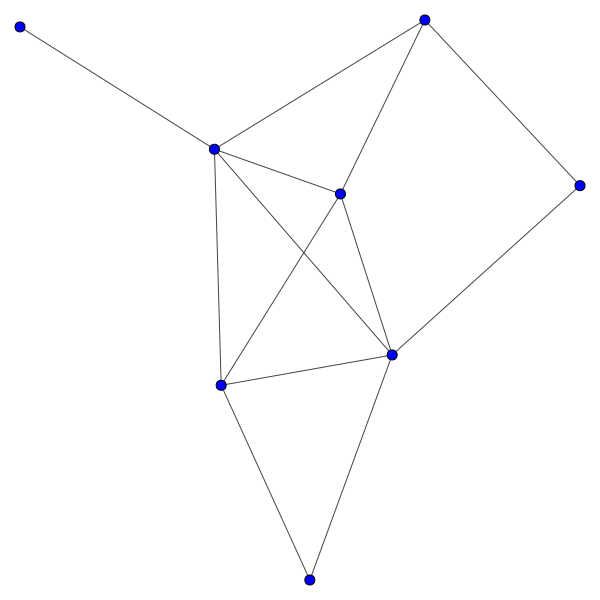

In [38]:
plot_sub_graph(big_component2, "graph_pvals0.001_cols10_2directions") #add True as a third parameter to save the file (default = not saving)

### Create connected components groups

In [27]:
components = gr.components()
subgraphs = components.subgraphs()

In [28]:
similarity_clusters = defaultdict(dict)
domain_to_cluster = {}
for i in range(len(subgraphs)):
    cluster = subgraphs[i]
    
    #Assign all the domains in the cluster the number i
    for domain in cluster.vs["name"]:
        domain_to_cluster[domain] = i
    
    #Save cluster attributes
    similarity_clusters[i]["domains"] = cluster.vs["name"]
    similarity_clusters[i]["degrees"] = cluster.degree()
    highest_degree_idx = np.where(cluster.degree() == np.max(cluster.degree()))[0]
    similarity_clusters[i]["highest_degree"] = np.array(cluster.vs["name"])[highest_degree_idx].tolist()
    
    shortest_paths = cluster.shortest_paths_dijkstra(weights="distances", mode="ALL")
    shortest_path_avg = [np.mean(x) for x in shortest_paths]
    mediod_idx = np.where(shortest_path_avg == min(shortest_path_avg))[0]
    similarity_clusters[i]["mediode"] = np.array(cluster.vs["name"])[mediod_idx].tolist()

In [33]:
similarity_clusters[33]

{'degrees': [3, 4, 5, 6, 5, 5, 6, 6],
 'domains': ['EF-hand_1',
  'EF-hand_4',
  'EF-hand_5',
  'EF-hand_6',
  'EF-hand_7',
  'EF-hand_8',
  'EF-hand_like',
  'S_100'],
 'highest_degree': ['EF-hand_6', 'EF-hand_like', 'S_100'],
 'mediode': ['EF-hand_6']}

In [34]:
#Save dictionaries
with open(curr_dir[0]+"/sim_clusters/pfam-v"+pfam_version+"/similarity_clusters_dict.pik", 'wb') as handle:
    pickle.dump(similarity_clusters, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(curr_dir[0]+"/sim_clusters/pfam-v"+pfam_version+"/domain_to_cluster_dict.pik", 'wb') as handle:
    pickle.dump(domain_to_cluster, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Draft code

In [61]:
pvals = significantly_similar_pairs["p-values"].tolist()
pval_per = np.percentile(pvals, 80)
gr.es["is_sig"] = [True if x <= pval_per else False for x in pvals]

In [68]:
np.percentile(pvals, 86)

9.8800000000000179e-05

In [12]:
scores = significantly_similar_pairs["scores"].tolist()
scores_per = np.percentile(scores, 10)
gr.es["is_high_score"] = [True if x >= 33 else False for x in scores]

In [39]:
np.percentile(scores, 50)

33.039999999999999

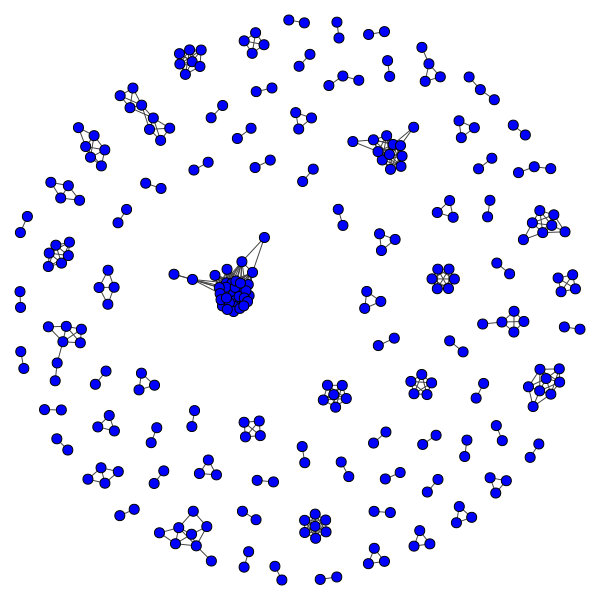

In [223]:
#Plotting the graph

visual_style = {}
visual_style["vertex_size"] = 10
visual_style["layout"] = gr.layout("fr")
visual_style["vertex_color"] = "blue"
#visual_style["edge_width"] = [1 + 2 * int(is_high_score) for is_high_score in gr.es["is_high_score"]]
#visual_style["vertex_label"] = gr.vs["name"]
plot(gr, **visual_style)
#plot(gr, "pfam-v"+pfam_version+"/graphs/score11_graph.pdf", **visual_style)